In [1]:
import torch

torch.set_default_dtype(torch.float64)

class NormalDistribution:
    def __init__(self, mean, logvar, v=None, r=None, A=None):
        """
        :param mean: mu in the paper
        :param logvar: \Sigma in the paper
        :param v:
        :param r:
        if A is not None then covariance matrix = A \Sigma A^T, where A = I + v^T r
        else the covariance matrix is simply diag(logvar.exp())
        """
        self.mean = mean
        self.logvar = logvar
        self.v = v
        self.r = r

        sigma = torch.diag_embed(torch.exp(logvar))
        if A is None:
            self.cov = sigma
        else:
            self.cov = A.bmm(sigma.bmm(A.transpose(1, 2)))


    @staticmethod
    def KL_divergence(q_z_next_pred, q_z_next):
        """
        :param q_z_next_pred: q(z_{t+1} | z_bar_t, q_z_t, u_t) using the transition
        :param q_z_next: q(z_t+1 | x_t+1) using the encoder
        :return: KL divergence between two distributions
        """
        mu_0 = q_z_next_pred.mean
        mu_1 = q_z_next.mean
        sigma_0 = torch.exp(q_z_next_pred.logvar)
        sigma_1 = torch.exp(q_z_next.logvar)
        v = q_z_next_pred.v
        r = q_z_next_pred.r
        k = float(q_z_next_pred.mean.size(1))

        sum = lambda x: torch.sum(x, dim=1)

        KL = 0.5 * torch.mean(sum((sigma_0 + 2*sigma_0*v*r) / sigma_1)
                              + sum(r.pow(2) * sigma_0) * sum(v.pow(2) / sigma_1)
                              + sum(torch.pow(mu_1-mu_0, 2) / sigma_1) - k
                              + 2 * (sum(q_z_next.logvar - q_z_next_pred.logvar) - torch.log(1 + sum(v*r)))
                              )
        return KL

In [2]:
# add input shape and output shape to the network at each layer if input =(batch_size,4)
from torch import nn

import pdb

from torch.autograd import Variable
import torch
from torch import nn


torch.set_default_dtype(torch.float64)

def weights_init(m):
    if type(m) in [nn.Conv2d, nn.Linear, nn.ConvTranspose2d]:
        torch.nn.init.orthogonal_(m.weight)

class Encoder(nn.Module):
    def __init__(self, net, obs_dim, z_dim):
        super(Encoder, self).__init__()
        self.net = net
        self.net.apply(weights_init)
        self.img_dim = obs_dim
        self.z_dim = z_dim

    def forward(self, x):
        """
        :param x: observation
        :return: the parameters of distribution q(z|x)
        """
        return self.net(x).chunk(2, dim = 1) # first half is mean, second half is logvar

class Decoder(nn.Module):
    def __init__(self, net, z_dim, obs_dim):
        super(Decoder, self).__init__()
        self.net = net
        self.net.apply(weights_init)
        self.z_dim = z_dim
        self.obs_dim = obs_dim

    def forward(self, z):
        """
        :param z: sample from q(z|x)
        :return: reconstructed x
        """
        return self.net(z)

class Transition(nn.Module):
    def __init__(self, net, z_dim, u_dim):
        super(Transition, self).__init__()
        self.net = net  # network to output the last layer before predicting A_t, B_t and o_t
        self.net.apply(weights_init)
        #pdb.set_trace()
        self.h_dim = self.net[-3].out_features
        self.z_dim = z_dim
        self.u_dim = u_dim

        self.fc_A = nn.Sequential(
            nn.Linear(self.h_dim, self.z_dim * 2), # v_t and r_t
            nn.Sigmoid()
        )
        self.fc_A.apply(weights_init)

        self.fc_B = nn.Linear(self.h_dim, self.z_dim * self.u_dim)
        torch.nn.init.orthogonal_(self.fc_B.weight)
        self.fc_o = nn.Linear(self.h_dim, self.z_dim)
        torch.nn.init.orthogonal_(self.fc_o.weight)
    def forward(self, z_bar_t, q_z_t, u_t):
        """
        :param z_bar_t: the reference point
        :param Q_z_t: the distribution q(z|x)
        :param u_t: the action taken
        :return: the predicted q(z^_t+1 | z_t, z_bar_t, u_t)
        """
        h_t = self.net(z_bar_t)
        B_t = self.fc_B(h_t)
        o_t = self.fc_o(h_t)
 


        v_t, r_t = self.fc_A(h_t).chunk(2, dim=1)

        v_t = torch.unsqueeze(v_t, dim=-1)
        r_t = torch.unsqueeze(r_t, dim=-2)

        A_t = torch.eye(self.z_dim).repeat(z_bar_t.size(0), 1, 1).to('cpu') + torch.bmm(v_t, r_t)

        B_t = B_t.view(-1, self.z_dim, self.u_dim)

        mu_t = q_z_t.mean

        mean1 = A_t.bmm(mu_t.unsqueeze(-1)).squeeze(-1) 
        mean2= B_t.bmm(u_t.unsqueeze(-1).unsqueeze(-1)).squeeze(-1) + o_t
        mean=mean1+mean2


        return mean, NormalDistribution(mean, logvar=q_z_t.logvar, v=v_t.squeeze(), r=r_t.squeeze(), A=A_t)
class Transition_2(nn.Module):
        def __init__(self, net, z_dim, u_dim):
            super(Transition_2, self).__init__()
            self.net = net  # network to output the last layer before predicting A_t, B_t and o_t
            self.net.apply(weights_init)
            #pdb.set_trace()
            self.h_dim = self.net[-3].out_features
            self.z_dim = z_dim
            self.u_dim = u_dim

            self.fc_A = nn.Sequential(
                nn.Linear(self.h_dim, self.z_dim * 2), # v_t and r_t
                nn.Sigmoid()
            )
            self.fc_A.apply(weights_init)

            self.fc_B = nn.Linear(self.h_dim, self.z_dim * self.u_dim)
            torch.nn.init.orthogonal_(self.fc_B.weight)
            #self.fc_o = nn.Linear(self.h_dim, self.z_dim)
            #torch.nn.init.orthogonal_(self.fc_o.weight)
        def forward(self, z_bar_t, u_t):
            """
            :param z_bar_t: the reference point
            :param Q_z_t: the distribution q(z|x)
            :param u_t: the action taken
            :return: the predicted q(z^_t+1 | z_t, z_bar_t, u_t)
            """
            h_t = self.net(z_bar_t)
            #h_t= torch.ones_like(h_t)
            B_t = self.fc_B(h_t)
            #o_t = self.fc_o(h_t)
    


            v_t, r_t = self.fc_A(h_t).chunk(2, dim=1)

            v_t = torch.unsqueeze(v_t, dim=-1)
            r_t = torch.unsqueeze(r_t, dim=-2)

            A_t = torch.eye(self.z_dim).repeat(z_bar_t.size(0), 1, 1).to('cpu') + torch.bmm(v_t, r_t)

            B_t = B_t.view(-1, self.z_dim, self.u_dim)

            mu_t = z_bar_t

            mean1 = A_t.bmm(mu_t.unsqueeze(-1)).squeeze(-1) 
            #mean2= B_t.bmm(u_t.unsqueeze(-1).unsqueeze(-1)).squeeze(-1) + o_t
            mean2= B_t.bmm(u_t.unsqueeze(-1).unsqueeze(-1)).squeeze(-1) 
            mean=mean1+mean2


            return mean, A_t, B_t

class springEncoder(Encoder):
    def __init__(self, obs_dim = 2, z_dim = 2):
        net = nn.Sequential(
            nn.Linear(obs_dim, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, z_dim * 2)
        )
        super(springEncoder, self).__init__(net, obs_dim, z_dim)

class springDecoder(Decoder):
    def __init__(self, z_dim = 2, obs_dim = 2):
        net = nn.Sequential(
            nn.Linear(z_dim, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),

            nn.Linear(150, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(),
            nn.Linear(150, obs_dim),
            nn.Sigmoid()
        )
        super(springDecoder, self).__init__(net, z_dim, obs_dim)

class springTransition(Transition):
    def __init__(self, z_dim = 2, u_dim = 1):
        net = nn.Sequential(
            nn.Linear(z_dim, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),

            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Sigmoid()
        )
        super(springTransition, self).__init__(net, z_dim, u_dim)
class springTransition_2(Transition_2):
    def __init__(self, z_dim = 2, u_dim = 1):
        net = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.Sigmoid()
        )
        super(springTransition_2, self).__init__(net, z_dim, u_dim)


class E2C(nn.Module):
    def __init__(self, obs_dim, z_dim, u_dim, env = 'experimental'):
        super(E2C, self).__init__()

        self.obs_dim = obs_dim
        self.z_dim = z_dim
        self.u_dim = u_dim

        self.encoder = springEncoder(obs_dim=obs_dim, z_dim=z_dim)
        # self.encoder.apply(init_weights)
        self.decoder = springDecoder(z_dim=z_dim, obs_dim=obs_dim)
        # self.decoder.apply(init_weights)
        self.trans = springTransition(z_dim=z_dim, u_dim=u_dim)
        # self.trans.apply(init_weights)

    def encode(self, x):
        """
        :param x:
        :return: mean and log variance of q(z | x)
        """
        #print(x.shape)
        return self.encoder(x)

    def decode(self, z):
        """
        :param z:
        :return: bernoulli distribution p(x | z)
        """
        return self.decoder(z)

    def transition(self, z_bar, q_z, u):
        """

        :return: samples z_hat_next and Q(z_hat_next)
        """
        return self.trans(z_bar, q_z, u)

    def reparam(self, mean, logvar,is_train=True):
        sigma = (logvar / 2).exp()
        epsilon = torch.randn_like(sigma)
        if(is_train):
          #print('yes')
          return mean + torch.mul(epsilon, sigma)
          
        else:
          print('yes') 
          return mean

    def forward(self, x, u, x_next,is_train=True):
        #pdb.set_trace()
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar,is_train)
        q_z = NormalDistribution(mu, logvar)

        x_recon = self.decode(z)

        z_next, q_z_next_pred = self.transition(z, q_z, u)
        x_next_pred = self.decode(z_next)
        mu_next, logvar_next = self.encode(x_next)
        q_z_next = NormalDistribution(mean=mu_next, logvar=logvar_next)

        return x_recon, x_next_pred, q_z, q_z_next_pred, q_z_next,z

    def predict(self, x, u):
        mu, logvar = self.encoder(x)
        z = self.reparam(mu, logvar)
        q_z = NormalDistribution(mu, logvar)

        z_next, q_z_next_pred = self.transition(z, q_z, u)

        x_next_pred = self.decode(z_next)
        return x_next_pred,z_next

In [3]:
import os
from os import path
import numpy as np
import json
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from tqdm import tqdm
import pickle
import torch
class experimental(Dataset):
    def __init__(self, dir):
        self.dir = dir
        with open(path.join(dir, 'data.json')) as f:
            self._data = json.load(f)
        self._process()
    def __len__(self):
        return len(self._data['samples'])
    def __getitem__(self, index):
        return self._processed[index]

    def _process(self):
        preprocessed_file = os.path.join(self.dir, 'processed.pkl')
        if not os.path.exists(preprocessed_file):
            processed = []
            for sample in tqdm(self._data['samples'], desc='processing data'):
                before = sample['before']
                after = sample['after']
                control = sample['control']

                processed.append((np.array(before), np.array(control), np.array(after)))

            with open(preprocessed_file, 'wb') as f:
                pickle.dump(processed, f)
            self._processed = processed
        else:
            with open(preprocessed_file, 'rb') as f:
                self._processed = pickle.load(f)

In [4]:
#from tensorboardX import SummaryWriter
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import argparse
import sys
import torch
import numpy as np
import os
import pdb
from torchsummary import summary

torch.set_default_dtype(torch.float64)

device = torch.device("cuda")


datasets = {'experimental':experimental}
settings = {'experimental':(8,8,1)}


num_eval=10
def compute_loss(x, x_next, q_z_next, x_recon, x_next_pred, q_z, q_z_next_pred, lamda):
    # lower-bound loss
    recon_term = -torch.mean(torch.sum(x * torch.log(1e-5 + x_recon)
                                       + (1 - x) * torch.log(1e-5 + 1 - x_recon), dim=1))
    pred_loss = -torch.mean(torch.sum(x_next * torch.log(1e-5 + x_next_pred)
                                      + (1 - x_next) * torch.log(1e-5 + 1 - x_next_pred), dim=1))

    kl_term = - 0.5 * torch.mean(torch.sum(1 + q_z.logvar - q_z.mean.pow(2) - q_z.logvar.exp(), dim = 1))

    #lower_bound = recon_term + pred_loss + kl_term
    lower_bound=recon_term + pred_loss+lamda*kl_term

    # consistency loss
    consis_term = NormalDistribution.KL_divergence(q_z_next_pred, q_z_next)
    return lower_bound + lamda * consis_term,recon_term,pred_loss,kl_term

def train(model, train_loader, lam, optimizer,scheduler):
    model.train()
    avg_loss = 0.0
    rec_loss = 0.0
    pred_loss = 0.0
    kl_loss = 0.0

    num_batches = len(train_loader)
    for i, (x, u, x_next) in enumerate(train_loader, 0):
        x = x.view(-1, model.obs_dim).double().to(device)
        u = u.double().to(device)
        x_next = x_next.view(-1, model.obs_dim).double().to(device)
        optimizer.zero_grad()
        x_recon, x_next_pred, q_z, q_z_next_pred, q_z_next ,_= model(x, u, x_next)

        loss,rec,pred,kl = compute_loss(x, x_next, q_z_next, x_recon, x_next_pred, q_z, q_z_next_pred, lam)
        rec_loss += rec.item()
        pred_loss += pred.item()
        #kl_loss += kl.item()
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return avg_loss / num_batches, pred_loss / num_batches, kl_loss / num_batches, rec_loss / num_batches
def train2(model, train_loader, lam, optimizer,scheduler):
    model.train()
    avg_loss = 0.0
    rec_loss = 0.0
    pred_loss = 0.0
    kl_loss = 0.0

    num_batches = len(train_loader)
    for i, (z, u, z_next) in enumerate(train_loader, 0):
        z = z.view(-1, model.z_dim).double().to(device)
        u = u.double().to(device)
        z_next = z_next.view(-1, model.z_dim).double().to(device)
        optimizer.zero_grad()
        #z_hat_next,A,B,o= model(z, u)
        z_hat_next,A,B= model(z, u)
        loss_func = torch.nn.MSELoss()
            
        loss= loss_func(z_hat_next, z_next)

        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return avg_loss / num_batches
def compute_log_likelihood(x, x_recon, x_next, x_next_pred):
    loss_1 = -torch.mean(torch.sum(x * torch.log(1e-5 + x_recon)
                                   + (1 - x) * torch.log(1e-5 + 1 - x_recon), dim=1))
    loss_2 = -torch.mean(torch.sum(x_next * torch.log(1e-5 + x_next_pred)
                                   + (1 - x_next) * torch.log(1e-5 + 1 - x_next_pred), dim=1))
    return loss_1, loss_2

def evaluate(model, test_loader):
    model.eval()
    num_batches = len(test_loader)
    state_loss, next_state_loss = 0., 0.
    with torch.no_grad():
        for x, u, x_next in test_loader:
            x = x.view(-1, model.obs_dim).double().to(device)
            u = u.double().to(device)
            x_next = x_next.view(-1, model.obs_dim).double().to(device)

            x_recon, x_next_pred, q_z, q_z_next_pred, q_z_next ,_= model(x, u, x_next)
            loss_1, loss_2 = compute_log_likelihood(x, x_recon, x_next, x_next_pred)
            state_loss += loss_1
            next_state_loss += loss_2

    return state_loss.item() / num_batches, next_state_loss.item() / num_batches

# code for visualizing the training process
def predict_x_next(model, env, num_eval):
    # frist sample a true trajectory from the environment
    sampler = samplers[env]
    state_samples, sampled_data = sampler.sample(num_eval)

    # use the trained model to predict the next observation
    predicted = []
    for x, u, x_next in sampled_data:
        x_reshaped = x.reshape(-1)
        x_reshaped = torch.from_numpy(x_reshaped).double().unsqueeze(dim=0).to(device)
        u = torch.from_numpy(u).double().unsqueeze(dim=0).to(device)
        with torch.no_grad():
            x_next_pred = model.predict(x_reshaped, u)
        predicted.append(x_next_pred.squeeze().cpu().numpy().reshape(sampler.width, sampler.height))
    true_x_next = [data[-1] for data in sampled_data]
    return true_x_next, predicted





In [7]:
env_name ='experimental'
propor = 0.9
batch_size = 1028
lr = 0.0001
weight_decay = 0.00001
lam = 0.25
epoches = 3000
iter_save = 100
seed =0
device='cpu'
np.random.seed(seed)
torch.manual_seed(seed)

dataset = datasets[env_name]('/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/Experimental_data/data' )
train_set, test_set = dataset[:int(len(dataset) * propor)], dataset[int(len(dataset) * propor):]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)
obs_dim, z_dim, u_dim = settings[env_name]
model = E2C(obs_dim=obs_dim, z_dim=z_dim, u_dim=u_dim, env=env_name).to(device)
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-8, lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20)

beta_start = 0.1
beta_end = 1.0
beta_steps = 10000
beta_step = (beta_end - beta_start) / beta_steps
beta = beta_start
for i in range(epoches):
    avg_loss,pred_loss,kl_loss,rec_loss = train(model, train_loader, beta, optimizer,scheduler)
    print('Epoch %d' % i)
    print("Training loss: %f" % (avg_loss))
    beta = min(beta + beta_step, beta_end)
    #print("rec loss: %f" % (rec_loss))
    #print("pred loss: %f" % (pred_loss))
    #print("KL loss: %f" % (kl_loss))

    # evaluate on test set
    state_loss, next_state_loss = evaluate(model, test_loader)
    #print('State loss: ' + str(state_loss))
    #print('Next state loss: ' + str(next_state_loss))
torch.save(model.state_dict(), '/model_' + str(i + 1))

Epoch 0
Training loss: 33.234514
Epoch 1
Training loss: 11.651663
Epoch 2
Training loss: 10.887465
Epoch 3
Training loss: 10.651664
Epoch 4
Training loss: 10.228091
Epoch 5
Training loss: 9.928892
Epoch 6
Training loss: 9.696025
Epoch 7
Training loss: 9.415958
Epoch 8
Training loss: 9.213475
Epoch 9
Training loss: 8.973903
Epoch 10
Training loss: 8.780251
Epoch 11
Training loss: 8.616713
Epoch 12
Training loss: 8.398631
Epoch 13
Training loss: 8.271817
Epoch 14
Training loss: 8.088566
Epoch 15
Training loss: 7.944218
Epoch 16
Training loss: 7.794271
Epoch 17
Training loss: 7.638417
Epoch 18
Training loss: 7.547541
Epoch 19
Training loss: 7.402464
Epoch 20
Training loss: 7.289053
Epoch 21
Training loss: 7.181441
Epoch 22
Training loss: 7.053588
Epoch 23
Training loss: 6.987135
Epoch 24
Training loss: 6.866993
Epoch 25
Training loss: 6.776434
Epoch 26
Training loss: 6.728021
Epoch 27
Training loss: 6.609049
Epoch 28
Training loss: 6.529516
Epoch 29
Training loss: 6.446776
Epoch 30
Traini

RuntimeError: File /model_3000 cannot be opened.

In [11]:
torch.set_default_dtype(torch.float32)




datasets = {'experimental': experimental}

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)
first_batch = next(iter(test_loader))
x=first_batch[0]
u=first_batch[1]
x_next=first_batch[2]
with torch.no_grad():
  device='cpu'
  x = x.view(-1, model.obs_dim).double().to(device)
  u = u.double().to(device)
  x_next = x_next.view(-1, model.obs_dim).double().to(device)
  mu,var= model.encode(x)
  x_next_pred,z_next= model.predict(x, u)
  x_next_pred=x_next_pred.cpu()
  x=x.cpu()
  x=x.detach().numpy()

  x_next_pred=x_next_pred.detach().numpy()
  sim_length=1


AttributeError: 'springTransition_2' object has no attribute 'encode'

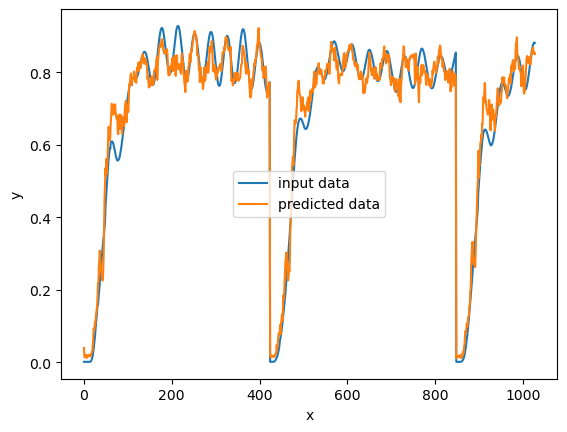

In [28]:
x1=x_next_pred
# Plot the two arrays
plt.plot(range(len(x)), x[:,0], label='input data')
plt.plot(range(len(x)), x1[:,0], label='predicted data')

# Add a legend and axis labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# Display the plot
plt.show()

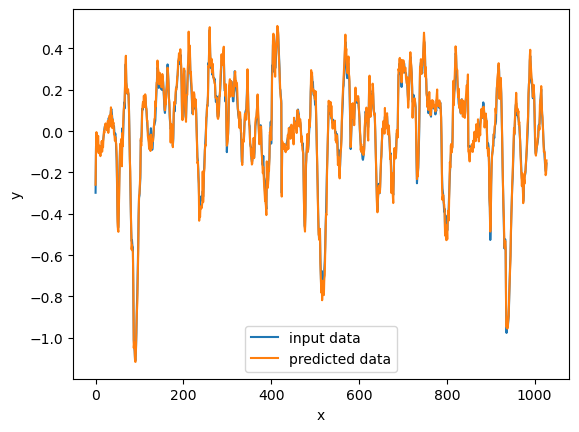

In [30]:


# Plot the two arrays
plt.plot(range(len(mu)), mu[:,2], label='input data')
plt.plot(range(len(mu)), z_next[:,2], label='predicted data')

# Add a legend and axis labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# Display the plot
plt.show()

In [32]:
# save model weights 
torch.save(model.state_dict(), '/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/Sim_data/model_weights.pt')


In [49]:

dataset = datasets[env_name]('/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/Sim_data/data_2' )
train_set, test_set = dataset[:int(len(dataset) * propor)], dataset[int(len(dataset) * propor):]
train_loader = DataLoader(train_set, batch_size=int(len(dataset) * propor), shuffle=False, drop_last=False)
first_batch = next(iter(train_loader))
x=first_batch[0]
u=first_batch[1]
x_next=first_batch[2]
with torch.no_grad():
  device='cpu'
  x = x.view(-1, model.obs_dim).double().to(device)
  x_next = x_next.view(-1, model.obs_dim).double().to(device)
  mu,var= model.encode(x)
  mu2,var2= model.encode(x_next)

processing data: 100%|██████████| 15999/15999 [00:00<00:00, 304157.14it/s]


In [50]:
u

tensor([0.0107, 0.0069, 0.0037,  ..., 0.9266, 0.9296, 0.9325],
       dtype=torch.float64)

In [2]:

# Plot the two arrays
plt.plot(range(len( mu[:100,0])), mu[1:101,2], label='input data')
plt.plot(range(len( mu[:100,0])), mu2[:100,2], label='predicted data')

# Add a legend and axis labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# Display the plot
plt.show()

NameError: name 'plt' is not defined

In [53]:
# save the decoded and encoded data
data1=[]
for i in range(len(mu)):
  data1.append((mu[i],mu2[i],u[i]))
torch.save(data1,'/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/Sim_data/latent_data.pt')

In [6]:
env_name ='experimental'
propor = 0.9
batch_size = 1028
lr = 0.0005
weight_decay = 0.00001
lam = 0.25
epoches = 3000
iter_save = 100
seed =0
device='cpu'
np.random.seed(seed)
torch.manual_seed(seed)

dataset = datasets[env_name]('/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/latent_2')
train_set, test_set = dataset[:int(len(dataset) * propor)], dataset[int(len(dataset) * propor):]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)
obs_dim, z_dim, u_dim = settings[env_name]
model = springTransition_2(8,1)
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), eps=1e-8, lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=epoches,eta_min=0.00001)

for i in range(epoches):
    avg_loss = train2(model, train_loader, 0, optimizer,scheduler)
    print('Epoch %d' % i)
    print("Training loss: %f" % (avg_loss))
    

Epoch 0
Training loss: 0.095499
Epoch 1
Training loss: 0.042130
Epoch 2
Training loss: 0.036824
Epoch 3
Training loss: 0.033948
Epoch 4
Training loss: 0.032276
Epoch 5
Training loss: 0.030775
Epoch 6
Training loss: 0.029710
Epoch 7
Training loss: 0.028886
Epoch 8
Training loss: 0.027947
Epoch 9
Training loss: 0.027192
Epoch 10
Training loss: 0.026796
Epoch 11
Training loss: 0.026016
Epoch 12
Training loss: 0.025452
Epoch 13
Training loss: 0.025363
Epoch 14
Training loss: 0.024987
Epoch 15
Training loss: 0.024236
Epoch 16
Training loss: 0.024286
Epoch 17
Training loss: 0.024004
Epoch 18
Training loss: 0.023277
Epoch 19
Training loss: 0.023188
Epoch 20
Training loss: 0.022577
Epoch 21
Training loss: 0.022904
Epoch 22
Training loss: 0.022723
Epoch 23
Training loss: 0.021641
Epoch 24
Training loss: 0.022020
Epoch 25
Training loss: 0.021513
Epoch 26
Training loss: 0.020829
Epoch 27
Training loss: 0.020582
Epoch 28
Training loss: 0.020486
Epoch 29
Training loss: 0.020644
Epoch 30
Training lo

KeyboardInterrupt: 

In [7]:

first_batch = next(iter(test_loader))
z=first_batch[0]
u=first_batch[1]
z_next=first_batch[2]
with torch.no_grad():
        z = z.view(-1, model.z_dim).double().to(device)
        u = u.double().to(device)
        z_next = z_next.view(-1, model.z_dim).double().to(device)
        optimizer.zero_grad()
        z_hat_next,A,B= model(z, u)

In [8]:
# save A , B , z 
data1=[]
for i in range(len(z)):
    data1.append((z[i],A[i],B[i]))
torch.save(data1,'/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/latent_2/control_data_local_test.pt')

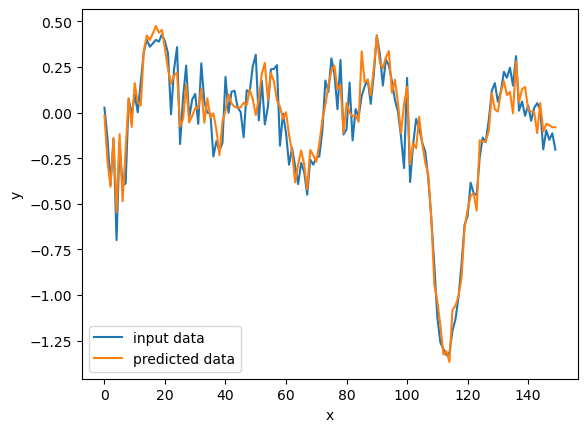

In [9]:

# Plot the two arrays
plt.plot(range(len( z_next[:150])),z_next[:150,0], label='input data')
plt.plot(range(len( z_hat_next[:150])), z_hat_next[:150,0], label='predicted data')

# Add a legend and axis labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# Display the plot
plt.show()

In [ ]:
A.shape

torch.Size([1028, 8, 8])

In [13]:
A[1]

tensor([[1.0003e+00, 3.0867e-05, 5.7328e-05, 1.7130e-02, 1.4627e-04, 4.7622e-04,
         2.7498e-04, 3.8454e-05],
        [2.1735e-04, 1.0000e+00, 4.3051e-05, 1.2864e-02, 1.0984e-04, 3.5762e-04,
         2.0650e-04, 2.8877e-05],
        [1.1689e-03, 1.2466e-04, 1.0002e+00, 6.9180e-02, 5.9073e-04, 1.9233e-03,
         1.1105e-03, 1.5530e-04],
        [3.9173e-05, 4.1777e-06, 7.7591e-06, 1.0023e+00, 1.9797e-05, 6.4454e-05,
         3.7217e-05, 5.2045e-06],
        [1.5660e-03, 1.6701e-04, 3.1017e-04, 9.2680e-02, 1.0008e+00, 2.5766e-03,
         1.4878e-03, 2.0805e-04],
        [7.6062e-05, 8.1118e-06, 1.5066e-05, 4.5017e-03, 3.8440e-05, 1.0001e+00,
         7.2264e-05, 1.0106e-05],
        [5.8595e-04, 6.2490e-05, 1.1606e-04, 3.4679e-02, 2.9613e-04, 9.6411e-04,
         1.0006e+00, 7.7850e-05],
        [3.0073e-03, 3.2072e-04, 5.9567e-04, 1.7799e-01, 1.5198e-03, 4.9482e-03,
         2.8572e-03, 1.0004e+00]])